In [1]:
from IPython.display import Image
from matplotlib import pyplot as plt
from python_functions import ppc_plot, StanModel_cache

import arviz
import numpy as np
import pandas as pd

plt.style.use('sparse.mplstyle')

Suppose we have some measurements from an experiment involving the following system of chemical reactions:

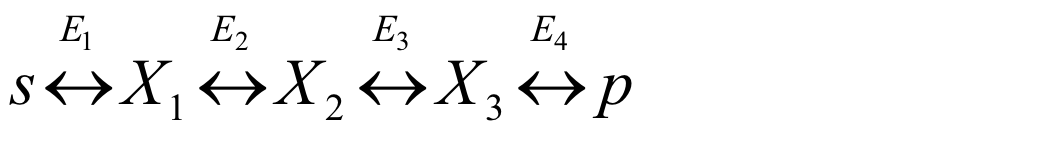

In [2]:
Image('equation.png')

Reactions 1, 3 and 4 are known to have the following underlying mechanism, which we shall call 'UniUni':

$$
\begin{align*}
E + S \iff ES \\
ES \iff EP \\
EP \iff E + P
\end{align*}
$$

In the first elementary reaction, the enzyme $E$ and substrate $S$ combine to form an enzyme-substrate complex $ES$. In the second elementary reaction, the substrate part of the complex turns into the product $P$, i.e. $ES$ turns into $EP$. In the third elementary reaction the product separates from the enzyme. While in normal conditions these reactions will all take place from left to right, for full generality we must also consider the reverse reaction in each case. In order to fully understand the reaction we therefore need to consider 6 elementary components.

Reaction 2 is assumed to be inhibited by the metabolite $X_3$. This reaction has a slightly more complicated elementary mechanism called 'Uni-Uni-inhib':

$$
\begin{align*}
E + S \iff ES \\
E + I \iff EI \\
ES \iff EP \\
EP \iff E + P
\end{align*}
$$

## Experiment
To carry out the experiment, the components of the system were left in a test tube, and the concentrations of the internal metabolites $X_1, ..., X_3$ were allowed to vary, while the concentrations of external metabolites $S$ and $P$, as well as the enzymes $E_1,..., E_4$ were kept constant. The tube was left for a long time in these conditions so that it eventually it became safe to assume that the concentrations of internal metabolites was no longer changing - in other words, the system had reached a 'steady state'. The internal metabolite concetrations were then measured, as was the overall flux through the system, called $v$. The experiment was repeated with a variety of enzyme and external metabolite concentrations, leading to the following results:

In [3]:
data = pd.read_csv('data.csv', index_col=0)
data

,E1,E2,E3,E4,s,p,X1,X2,X3,v
Ex_1,1,1,1,2,1.0,1,0.90,0.9,0.75,0.11
Ex_2,1,2,1,1,1.0,1,0.90,1.2,1.10,0.12
Ex_3,1,1,1,1,0.5,2,0.65,0.9,1.30,0.05
Ref,1,1,1,1,1.0,1,1.00,1.0,1.00,0.10


## Modelling strategy
This notebook explores how to learn from this data, taking advantage of the rich information that is available about how the underlying reaction system. The overall strategy is as follows:

1. Formulate a rate equation for each reaction, specifying how fast it will proceed as a function of some unknown parameters and known experimental conditions.
2. Use our knowledge of the overall reaction system to express the rates of change of each internal metabolite concentration as a function of the system's rate equations - at steady state this rate will be zero.
3. Solve the resulting system of ordinary differential equations so that (at steady state) the internal metabolite concentrations can be expressed as  functions of parameters and conditions governing rate equations.
4. Express non-experimental information about the reactions as probability distributions over the unknown parameters, and express the experimental information as a probabilistic measurement model.
5. Combine the experimental and non-experimental information with a Bayesian statistical model.

For simplicity we use the same simple measurement model in each case - measured concentrations and fluxes are unbiased draws from a normal distribution centered at the true values, with known variance. 

The notebook will explore three different ways of parameterising the system's reaction rates and representing the available information as probability distributions over these parameters' possible values.

1. **Big K**

   This approach represents each reaction's rate in terms of macroscopic parameters, with the elementary reactions not being represented explicitly. Each macroscopic parameter is given a weakly informative prior distribition.
   
   
2. **Small k**

   Reaction rates are parameterised in terms of elementary reaction constants. Each elementary rate constant is given a weakly informative prior.
   

3. **Auxiliary parameters**

   Reaction rates are written as functions of elementary reaction constants, which are themselves determined by auxiliary parameters, namely thermodynamic factors and relative enzyme abundances and reaction reversibilities. The auxiliary parameters are given weakly informative prior distributions, taking into account that the relative parameters have to sum to one.
   
The Big K approach has the fewest parameters and is easiest to implement; however it is not fully general. In addition, it is challenging to find prior distributions that give appropriately low probability to thermodynamically infeasible parameter configurations.

The Small k approach is more general, but does not solve the problem of ensuring thermodynamic feasibility and somewhat over-parameterised.

The auxiliary parameters approach requires a more complicated model that can convert auxiliary parameters to elementary rate constants, but in doing so should address the problem of thermodynamic feasibility.

# Big k model

The 'big k' model parameterises the reactions' rates as follows:

$$
\begin{align*}
v_1&=E_1\cdot\frac{Kcat_1\cdot(S-X_1/Keq_1)}{S+Km_1+X_1/Keq_1} \\
v_2&=E_2\cdot\frac{Kcat_2\cdot(X_1-X_2/Keq_2)}{X_1+Km_2+X_2/Keq_2}\cdot\frac{1}{1+X_3/KI_2} \\
v_3&=E_3\cdot\frac{Kcat_3\cdot(X_2-X_3/Keq_3)}{X_2+Km_3+X_3/Keq_3} \\
v_4&=E_4\cdot\frac{Kcat_4\cdot(X_3-P/Keq_4)}{X_3+Km_4+P/Keq_4} \\
\end{align*}
$$

where $Kcat$, $Km$ and $Keq$ are enzyme-specific constants and $KI_2$ represents the extent to which the concentration of metabolite $X_3$ inhibits reaction 2. See [here](????) for more about the interpretation of these parameters.

These rate equations can be incorporated into our method using the following Stan functions:

In [4]:
with open("big_k_equations.stan", "r") as f:
    print(f.read())

real[] flux_equations_big_k(vector X, vector theta, real[] x_r){
  real E[4] = x_r[1:4];
  real S = x_r[5];
  real P = x_r[6];
  real k_cat[4] = to_array_1d(theta[1:4]);
  real K_eq[4] = to_array_1d(theta[5:8]);
  real K_m[4] = to_array_1d(theta[9:12]);
  real K_I = theta[13];
  real fluxes[4];

  fluxes[1] = E[1] * k_cat[1] * (S - X[1] / K_eq[1]) / (S + K_m[1] + X[1] / K_eq[1]);
  fluxes[2] = E[2] * k_cat[2] * (X[1] - X[2] / K_eq[2]) / (X[1] + K_m[2] + X[2] / K_eq[2]) / (1 + X[3] / K_I);
  fluxes[3] = E[3] * k_cat[3] * (X[2] - X[3] / K_eq[3]) / (X[2] + K_m[3] + X[3] / K_eq[3]);
  fluxes[4] = E[4] * k_cat[4] * (X[3] - P / K_eq[4]) / (X[3] + K_m[4] + P    / K_eq[4]);
  return fluxes;
}
vector steady_state_equations_big_k(vector y, vector theta, real[] x_r, int[] x_i){
  real flux[4] = flux_equations_big_k(y, theta, x_r);
  vector[3] roots;

  roots[1] = flux[1] - flux[2];
  roots[2] = flux[2] - flux[3];
  roots[3] = flux[3] - flux[4];
  return roots;
}



The following Stan program uses these functions to define a joint probability distribution for the data and the 'big k' parameters:

In [5]:
with open("reaction_model_big_k.stan", "r") as f:
    print(f.read())

functions {
#include big_k_equations.stan
}
data {
  // experimental data
  int<lower=1> N_metabolite;
  int<lower=1> N_controlled;
  int<lower=1> N_experiment;
  real measured_metabolite[N_experiment, N_metabolite];
  real controlled_concentration[N_experiment, N_controlled];
  real measured_flux[N_experiment];
  // hardcoded priors
  vector<lower=0>[N_metabolite] sigma_metabolite;
  real<lower=0> sigma_flux;
  vector[3] enzyme_parameter_mean;
  vector<lower=0>[3] enzyme_parameter_sd;
  real KI_mean;
  real KI_sd;
  // model config
  real rel_tol;
  real f_tol;
  int max_steps;
  int<lower=0,upper=1> LIKELIHOOD;
}
parameters {
  vector<lower=0>[4] Kcat;
  vector<lower=0>[4] Keq;
  vector<lower=0>[4] Km;
  real<lower=0> KI;
}
transformed parameters {
  matrix[N_experiment, N_metabolite] metabolite_hat; 
  real flux_hat[N_experiment, 4]; 
  for (e in 1:N_experiment){
    vector[13] theta = append_row(append_row(append_row(Kcat, Keq), Km), KI);
    int x_i[0];
    metabolite_hat[e] = alg

The next cell compiles the big k model, sets some priors and then draws samples from the posterior distribution.

In [6]:
model_big_k = StanModel_cache(file='reaction_model_big_k.stan')

# Hardcoded priors
# how accurate were the measurements for each metabolite?
sigma_metabolite = [0.05, 0.05, 0.05]
# how accurate were the flux measurements?
sigma_flux = 0.02
# enzyme parameter locations and scales
enzyme_parameter_mean = [0, 0, 0]
enzyme_parameter_sd = [0.5, 0.5, 0.5]
# inhibition parameter location and scale
K_I_mean = 0
K_I_sd = 0.5

# Equation solver config
rel_tol = 1e-7
f_tol = 1e-6
max_steps = int(1e6)

# Define model input
experiments = ['Ref', 'Ex_1', 'Ex_2', 'Ex_3']
controlled_concentrations = ['E1', 'E2', 'E3', 'E4', 's', 'p']
enzymes = ['E1', 'E2', 'E3', 'E4']
metabolites = ['X1', 'X2', 'X3']
flux = 'v'
model_data_big_k = {
    # experiment results
    'N_metabolite': len(metabolites),
    'N_controlled': len(controlled_concentrations),
    'N_experiment': len(experiments),
    'measured_metabolite': data.loc[experiments, metabolites],
    'measured_flux': data.loc[experiments, flux],
    'controlled_concentration': data.loc[experiments, controlled_concentrations],
    # hardcoded priors
    'sigma_metabolite': sigma_metabolite,
    'sigma_flux': sigma_flux,
    'enzyme_parameter_mean': enzyme_parameter_mean,
    'enzyme_parameter_sd': enzyme_parameter_sd,
    'KI_mean': K_I_mean,
    'KI_sd': K_I_sd,
    # config
    'rel_tol': rel_tol,
    'f_tol': f_tol,
    'max_steps': max_steps
}
data_big_k_prior = {**model_data_big_k, **{'LIKELIHOOD': 0}}
data_big_k_posterior = {**model_data_big_k, **{'LIKELIHOOD': 1}}

# Sample from prior and posterior distribution
fit_big_k_prior = model_big_k.sampling(data=data_big_k_prior, 
                                       iter=1000,
                                       chains=4)
fit_big_k_posterior = model_big_k.sampling(data=data_big_k_posterior,
                                           iter=1000,
                                           chains=4)

# Store model output as an arviz InferenceData object
infd_big_k = arviz.from_pystan(
    posterior=fit_big_k_posterior,
    posterior_predictive='metabolite_pred',
    prior_predictive='metabolite_pred',
    observed_data='measured_metabolite',
    prior=fit_big_k_prior,
    coords={'experiments': experiments,
            'metabolites': metabolites,
            'enzymes': ['E1', 'E2', 'E3', 'E4']},
    dims={'Kcat': ['enzymes'], 
          'Keq': ['enzymes'],
          'Km': ['enzymes'],
          'measured_metabolite': ['experiments', 'metabolites'],
          'metabolite_pred': ['experiments', 'metabolites'],
          'metabolite_hat': ['experiments', 'metabolites']}
)
infd_big_k.to_netcdf('output/model_output_big_k.nc')

# Print summary statistics
arviz.summary(infd_big_k.posterior, var_names=['Kcat', 'Keq', 'Km', 'KI'])

Using cached StanModel


,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
Kcat[0],0.75,0.21,0.01,0.41,1.13,1072.0,1.0
Kcat[1],0.56,0.19,0.01,0.25,0.88,1318.0,1.0
Kcat[2],0.67,0.18,0.00,0.37,0.99,1415.0,1.0
Kcat[3],0.66,0.17,0.00,0.40,0.98,1281.0,1.0
Keq[0],1.66,0.24,0.00,1.29,2.16,1174.0,1.0
Keq[1],1.65,0.16,0.00,1.35,1.96,1908.0,1.0
Keq[2],1.82,0.22,0.00,1.43,2.20,1378.0,1.0
Keq[3],1.86,0.13,0.00,1.62,2.10,1447.0,1.0
Km[0],1.17,0.59,0.02,0.30,2.29,1246.0,1.0
Km[1],1.45,0.74,0.01,0.34,2.78,1517.0,1.0


To check that the model behaved as expected, the next cell finds the posterior draws with the highest and lowest values of some diagnostic statistics:

In [7]:
def highlight_min_and_max(s):
    '''
    highlight the maximum in a Series red and the minimum blue.
    '''
    
    is_max = s == s.max()
    is_min = s == s.min()
    
    out = pd.Series('', index=s.index)
    out.loc[is_max] = 'background-color: red'
    out.loc[is_min] = 'background-color: blue'
    return out


diagnostic_df = infd_big_k.sample_stats.to_dataframe()

interesting_columns = ['treedepth', 'n_leapfrog', 'stepsize', 'energy']

max_indices = diagnostic_df[interesting_columns].idxmax()
min_indices = diagnostic_df[interesting_columns].idxmin()

(
    diagnostic_df
    .loc[pd.concat([max_indices, min_indices]), interesting_columns]
    .drop_duplicates()
    .style.apply(highlight_min_and_max)
)

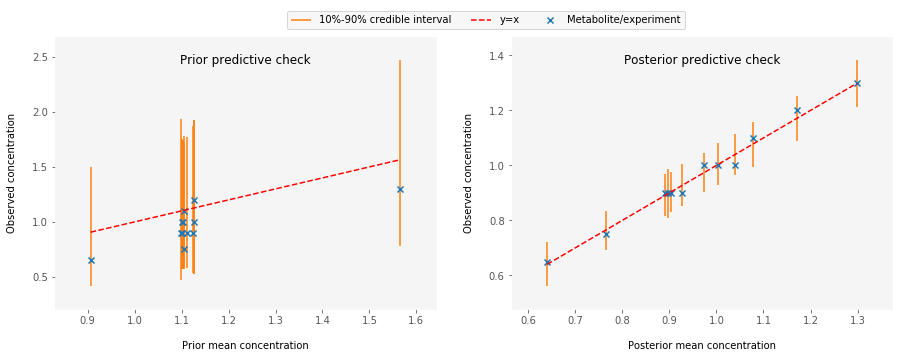

In [8]:
ppc_plot(infd_big_k)

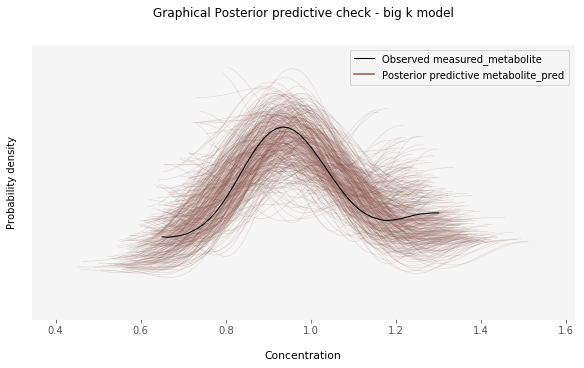

In [9]:
arviz.plot_ppc(infd_big_k, kind='density',
               mean=False,
               figsize=[8, 5],
               num_pp_samples=400,
               textsize=10,
               data_pairs={'measured_metabolite': 'metabolite_pred'})

ax = plt.gca()
text = ax.set(
    xlabel='Concentration', ylabel='Probability density',
    title='Graphical Posterior predictive check - big k model'
)

# Small k model
Instead of using macroscopic parameters, we could instead describe the reactions' rates in terms of rate constants of elementary reactions. The resulting equations would look something like this:

$$
\begin{align*}
v_1&=\frac{k_{12}k_{14}k_{16}S - k_{11}k_{13}k_{15}X1}{(k_{14}k_{16} + k_{12}(k_{13} + k_{14} + k_{16})S + k_{13}k_{15}X1 + k_{14}k_{15}X1 + k_{11}(k_{13} + k_{16} + k_{15}X1))} \\
v_2&=\frac{k_{27}(k_{22}k_{24}k_{26}X1 - k_{21}k_{23}k_{25}X2)}{k_{24}k_{26}k_{27} + k_{22}(k_{23} + k_{24} + k_{26})k_{27}X1 + k_{23}k_{25}k_{27}X2 + k_{24}k_{25}k_{27}X2 + k_{24}k_{26}k_{28}X3 + k_{21}(k_{25}k_{27}X2 + k_{23}(k_{27} + k_{28}X3) + k_{26}(k_{27} + k_{28}X3))}\\
v_3&=\frac{k_{32}k_{34}k_{36}X_2 - k_{31}k_{33}k_{35}X_3}{(k_{34}k_{36} + k_{32}(k_{33} + k_{34} + k_{36})X_2 + k_{33}k_{35}X_3 + k_{34}k_{35}X_3 + k_{31}(k_{33} + k_{36} + k_{35}X_3))}\\
v_4&=\frac{k_{42}k_{44}k_{46}X_3 - k_{41}k_{43}k_{45}X_4}{(k_{44}k_{46} + k_{42}(k_{43} + k_{44} + k_{46})X_3 + k_{43}k_{45}X_4 + k_{44}k_{45}X_4 + k_{41}(k_{43} + k_{46} + k_{45}X_4))}\\
\end{align*}
$$

The uninhibited reactions 1, 3 and 4 have 6 elementary rate constants each, while the inhibited reaction 2 has 8. These equations can be represented in Stan very similarly to the macroscopic ones:

In [10]:
with open("small_k_equations.stan", "r") as f:
    print(f.read())

real[] flux_equations_small_k(vector X, vector small_k, real[] controlled_concentrations){
  real S = controlled_concentrations[5];
  real P = controlled_concentrations[6];
  real E[4] = controlled_concentrations[1:4];
  vector[6] k1 = segment(small_k, 1, 6);
  vector[8] k2 = segment(small_k, 7, 8);
  vector[6] k3 = segment(small_k, 16, 6);
  vector[6] k4 = segment(small_k, 21, 6);
  real fluxes[4];
  fluxes[1] = E[1] * (k1[1]*k1[3]*k1[5]*S - k1[2]*k1[4]*k1[6]*X[1]) /
    (k1[3]*k1[5]
     + k1[1]*(k1[4] + k1[3] + k1[5])*S
     + k1[4]*k1[6]*X[1]
     + k1[3]*k1[6]*X[1]
     + k1[2]*(k1[4] + k1[5] + k1[6]*X[1]));
  fluxes[2] = E[2] * (k2[8]*(k2[1]*k2[3]*k2[5]*X[1] - k2[2]*k2[4]*k2[6]*X[2])) /
    (k2[3]*k2[5]*k2[8]
     + k2[1]*(k2[4] + k2[3] + k2[5])*k2[8]*X[1]
     + k2[4]*k2[6]*k2[8]*X[2]
     + k2[3]*k2[6]*k2[8]*X[2]
     + k2[3]*k2[5]*k2[7]*X[3]
     + k2[2]*(k2[6]*k2[8]*X[2] + k2[4]*(k2[8] + k2[7]*X[3]) + k2[5]*(k2[8] + k2[7]*X[3])));
  fluxes[3] = E[3] * (k3[1]*k3[3]*k3[5]*X[2] 

Here is the model we can use to:

In [11]:
with open("reaction_model_small_k.stan", "r") as f:
    print(f.read())

functions {
#include small_k_equations.stan
}
data {
  // experimental data
  int<lower=1> N_metabolite;
  int<lower=1> N_controlled;
  int<lower=1> N_experiment;
  real measured_metabolite[N_experiment, N_metabolite];
  real controlled_concentration[N_experiment, N_controlled];
  vector[N_experiment] measured_flux;
  // hardcoded priors
  real k_loc;
  real<lower=0> k_scale;
  vector<lower=0>[N_metabolite] sigma_metabolite;
  real<lower=0> sigma_flux;
  // model config
  real rel_tol;
  real f_tol;
  int max_steps;
  int<lower=0,upper=1> LIKELIHOOD;
}
parameters {
  vector<lower=0>[26] k;
}
transformed parameters {
  matrix[N_experiment, N_metabolite] metabolite_hat; 
  real flux_hat[N_experiment, 4]; 
  for (e in 1:N_experiment){
    int x_i[0];
    metabolite_hat[e] = algebra_solver(steady_state_equations_small_k,
                                       rep_vector(0.1, 3),
                                       k,
                                       controlled_concentration[e],
  

The next cell fits the small k model.

In [12]:
model_small_k = StanModel_cache(file='reaction_model_small_k.stan')

# Hardcoded priors
# how accurate were the measurements for each metabolite?
sigma_metabolite = [0.05, 0.05, 0.05]
# how accurate were the flux measurements?
sigma_flux = 0.02
# locations and scales for small k parameters
k_loc = 0
k_scale = 0.5

# Equation solver config
rel_tol = 1e-9
f_tol = 1e-6
max_steps = int(1e9)

# Define model input
experiments = ['Ref', 'Ex_1', 'Ex_2', 'Ex_3']
controlled_concentrations = ['E1', 'E2', 'E3', 'E4', 's', 'p']
enzymes = ['E1', 'E2', 'E3', 'E4']
metabolites = ['X1', 'X2', 'X3']
flux = 'v'
model_data_small_k = {
    # experiment results
    'N_metabolite': len(metabolites),
    'N_controlled': len(controlled_concentrations),
    'N_experiment': len(experiments),
    'measured_metabolite': data.loc[experiments, metabolites],
    'measured_flux': data.loc[experiments, flux],
    'controlled_concentration': data.loc[experiments, controlled_concentrations],
    # hardcoded priors
    'sigma_metabolite': sigma_metabolite,
    'sigma_flux': sigma_flux,
    'k_loc': k_loc,
    'k_scale': k_scale,
    # config
    'rel_tol': rel_tol,
    'f_tol': f_tol,
    'max_steps': max_steps
}
data_small_k_prior = {**model_data_small_k, **{'LIKELIHOOD': 0}}
data_small_k_posterior = {**model_data_small_k, **{'LIKELIHOOD': 1}}

# Sample from prior and posterior distribution
fit_small_k_prior = model_small_k.sampling(data=data_small_k_prior, 
                                           iter=1000,
                                           chains=4)
fit_small_k_posterior = model_small_k.sampling(data=data_small_k_posterior,
                                               iter=1000,
                                               chains=4)

# Store model output as an arviz InferenceData object
infd_small_k = arviz.from_pystan(
    posterior=fit_small_k_posterior,
    posterior_predictive='metabolite_pred',
    prior_predictive='metabolite_pred',
    observed_data='measured_metabolite',
    prior=fit_small_k_prior,
    coords={'experiments': experiments,
            'metabolites': metabolites},
    dims={'measured_metabolite': ['experiments', 'metabolites'],
          'metabolite_pred': ['experiments', 'metabolites'],
          'metabolite_hat': ['experiments', 'metabolites']}
)
infd_small_k.to_netcdf('output/model_output_small_k.nc')

# Print summary statistics
arviz.summary(infd_small_k.posterior, var_names=['k'])

Using cached StanModel


,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
k[0],1.28,0.53,0.01,0.47,2.24,2396.0,1.0
k[10],1.52,0.63,0.01,0.56,2.65,2912.0,1.0
k[11],1.33,0.58,0.02,0.46,2.37,1892.0,1.0
k[12],0.94,0.44,0.01,0.29,1.78,2239.0,1.0
k[13],1.34,0.68,0.02,0.42,2.57,1987.0,1.0
k[14],1.13,0.57,0.00,0.29,2.15,3034.0,1.0
k[15],1.23,0.49,0.01,0.49,2.15,2331.0,1.0
k[16],1.02,0.46,0.01,0.34,1.92,1916.0,1.0
k[17],1.38,0.55,0.02,0.58,2.35,2076.0,1.0
k[18],0.93,0.44,0.01,0.32,1.84,2373.0,1.0


[array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123107be0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123107be0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123107be0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123107be0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123107be0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123107be0>,
       dtype=object)]

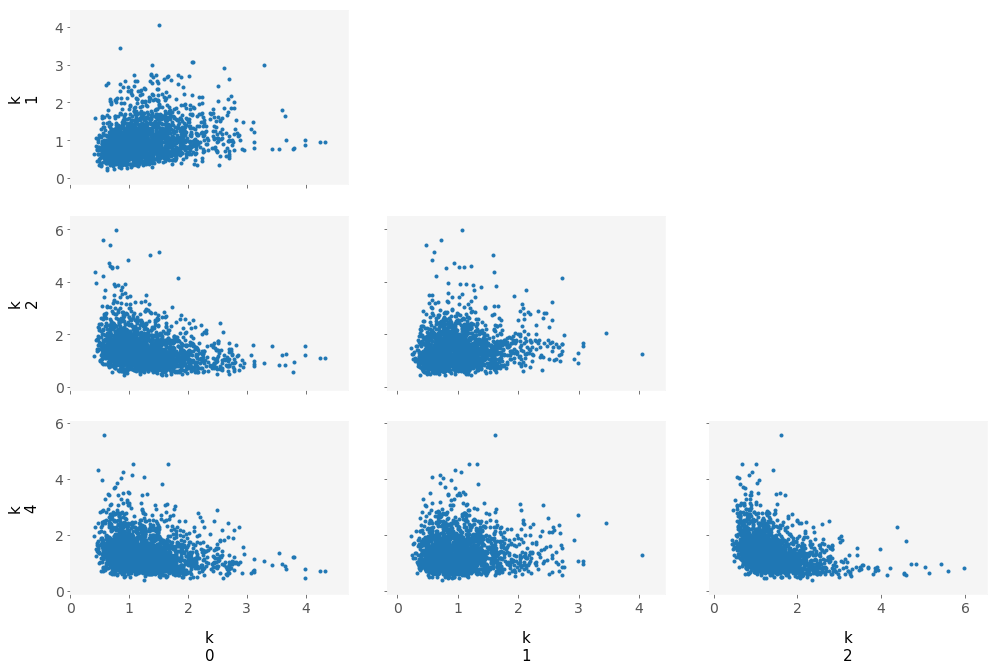

In [13]:
arviz.plot_pair(infd_small_k, var_names=['k'], coords={'k_dim_0': [0, 1, 2, 4]})

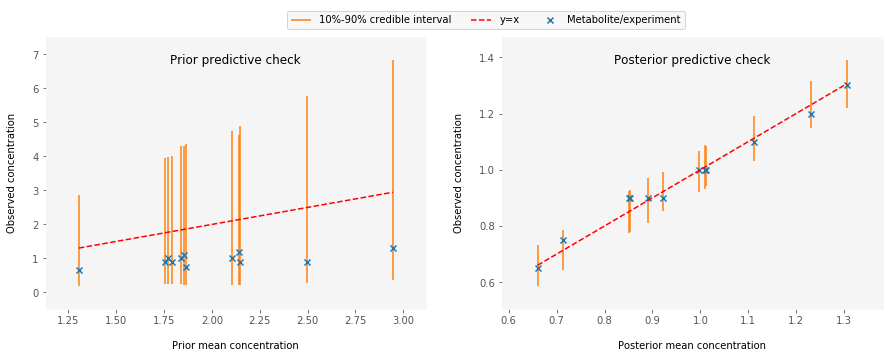

In [14]:
ppc_plot(infd_small_k)

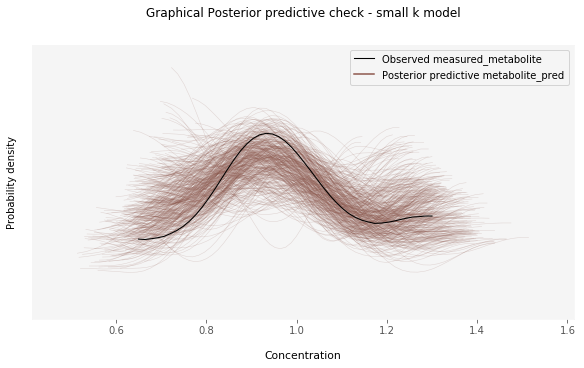

In [15]:
arviz.plot_ppc(infd_small_k, kind='density',
               mean=False,
               figsize=[8, 5],
               num_pp_samples=400,
               textsize=10,
               data_pairs={'measured_metabolite': 'metabolite_pred'})

ax = plt.gca()
text = ax.set(
    xlabel='Concentration', ylabel='Probability density',
    title='Graphical Posterior predictive check - small k model'
)

The fit is clearly worse than in the big k case - this is perhaps because of the worse priors, and could also be due to the parameters not being identified by the data.


# Small k model with auxiliary parameters

To ensure that prior probability mass is only given to thermodynamically feasible regions of small k space, we can reparameterise the model in terms of auxiliary parameters. The parameters in the new model are relative enzyme abundances, relative elementary reaction reversibilities and operational gibbs energies.

These auxiliary parameters, together with the overall reaction flux, determine the elementary rate constants for each reaction, with the precise relationship depending on the mechanism. Here is the relationships for the two mechansims in our example:

In [16]:
with open('get_small_k_uni_uni.stan', 'r') as f:
    print(f.read())
    
with open('get_small_k_uni_uni_inhib.stan', 'r') as f:
    print(f.read())

vector get_small_k_uni_uni(vector enzyme_abundance_raw,
                           vector reversibility_proportional,
                           real gibbs,
                           real reaction_flux){
  /* 
     Get elementary rate constants for a reaction with the following mechanism:
     1. E + A <-> EA
     2. EA <-> EP
     3. EP <-> E + P
     
     Method is mostly copied from the GRASP file `calculateKineticParams.m`,
     however the transformation from `reversibility_proportional` to
     `reversibility` is copied from `sampleGeneralReversibilities.m`.
  */

  real RT = 2.4788;
  int enzyme_index[6] = {1, 2, 2, 3, 3, 1};
  int irrev_ix[3] = {1, 3, 5};
  int rev_ix[3] = {2, 4, 6};

  vector[3] reversibility = exp(reversibility_proportional * (gibbs / RT));
  vector[6] enzyme_abundance = enzyme_abundance_raw[enzyme_index];

  vector[6] elementary_flux;
  elementary_flux[irrev_ix] = inv(1-reversibility);
  elementary_flux[rev_ix] = reversibility .* inv(1-reversibility);

  r

## Testing that the functions behave as expected

The Stan code using auxilliary parameters uses some functions that I copied somewhat cautiously from GRASP. I used the cells below to test whether these functions were working properly.

The first cell tests the function `get_small_k_uni_uni.stan` against some numbers from GRASP.

In [17]:
uni_uni_model = StanModel_cache(file='test_get_small_k_uni_uni.stan')

reversibility_proportional = np.array([0.1140, 0.4452, 0.4408])
enzyme_abundance_raw = np.array([0.7899, 0.0654, 0.1447])
expected_result = np.array([ 0.3402, 2.4271, 1.9285, 0.1115, 0.8744, 0.0209])
gibbs = -11.4499
reaction_flux = 0.11
RT = 2.4788

model_data_test_uni_uni = {
    'reversibility_proportional': reversibility_proportional,
    'enzyme_abundance_raw': enzyme_abundance_raw,
    'gibbs': gibbs,
    'reaction_flux': reaction_flux
}

uni_uni_fit = uni_uni_model.sampling(data=model_data_test_uni_uni, iter=1, chains=1, algorithm='Fixed_param')
function_result = uni_uni_fit['small_k'].reshape(-1).round(4)

print(f'expected result: {expected_result}')
print(f'function result: {function_result}')

Using cached StanModel
expected result: [0.3402 2.4271 1.9285 0.1115 0.8744 0.0209]
function result: [0.3402 2.4266 1.9286 0.1115 0.8743 0.0209]


The next cell uses the same method to test the Stan function `get_small_k_uni_uni_inhib`. The only difference is that this  function needs one more input - `elementary_flux_modifier`.

In [18]:
uni_uni_inhib_model = StanModel_cache(file='test_get_small_k_uni_uni_inhib.stan')
reversibility_proportional = np.array([0.1252, 0.5721, 0.3027])
enzyme_abundance_raw = np.array([0.1926, 0.1294, 0.2662, 0.4118])
expected_result = np.array([0.9178 ,0.5159, 0.6231, 0.3029, 0.8601, 0.0032, 0.2952, 0.0599])
gibbs = -19.2777
reaction_flux = 0.11
RT = 2.4788
elementary_flux_modifier = 0.7330

model_data_test_uni_uni_inhib = {
    'reversibility_proportional': reversibility_proportional,
    'enzyme_abundance_raw': enzyme_abundance_raw,
    'gibbs': gibbs,
    'reaction_flux': reaction_flux,
    'elementary_flux_modifier': elementary_flux_modifier
}

uni_uni_inhib_fit = uni_uni_inhib_model.sampling(data=model_data_test_uni_uni_inhib,
                                                 iter=1,
                                                 chains=1,
                                                 algorithm='Fixed_param')
function_result = uni_uni_inhib_fit['small_k'].reshape(-1).round(4)

print(f'expected result: {expected_result}')
print(f'function result: {function_result}')

Using cached StanModel
expected result: [0.9178 0.5159 0.6231 0.3029 0.8601 0.0032 0.2952 0.0599]
function result: [0.9178 0.5159 0.6231 0.3029 0.8601 0.0032 0.2952 0.0599]


In [19]:
model_auxiliary = StanModel_cache(file='reaction_model_auxiliary.stan')

# Hardcoded priors
# how accurate were the measurements for each metabolite?
sigma_metabolite = [0.05, 0.05, 0.05]
# how accurate were the flux measurements?
sigma_flux = 0.02
# dirichlet hyperparameters for simplex parameters
dir_rev = 3
dir_enz = 3
# location and scale for operational gibbs energies
gibbs_mean = -6
gibbs_sd = 2
# beta params for inhibition modifier
inhibition_modifier_beta_params = [2, 2]

# Equation solver config
rel_tol = 1e-9
f_tol = 1e-6
max_steps = int(1e9)

# Define model input
experiments = ['Ref', 'Ex_1', 'Ex_2', 'Ex_3']
controlled_concentrations = ['E1', 'E2', 'E3', 'E4', 's', 'p']
enzymes = ['E1', 'E2', 'E3', 'E4']
metabolites = ['X1', 'X2', 'X3']
flux = 'v'
model_data_auxiliary = {
    # experiment results
    'N_metabolite': len(metabolites),
    'N_controlled': len(controlled_concentrations),
    'N_experiment': len(experiments),
    'measured_metabolite': data.loc[experiments, metabolites],
    'measured_flux': data.loc[experiments, flux],
    'controlled_concentration': data.loc[experiments, controlled_concentrations],
    # hardcoded priors
    'sigma_metabolite': sigma_metabolite,
    'sigma_flux': sigma_flux,
    'gibbs_mean': gibbs_mean,
    'gibbs_sd': gibbs_sd,
    'dir_enz': dir_enz,
    'dir_rev': dir_rev,
    'inhibition_modifier_beta_params': inhibition_modifier_beta_params,
    # config
    'rel_tol': rel_tol,
    'f_tol': f_tol,
    'max_steps': max_steps
}
data_auxiliary_prior = {**model_data_auxiliary, **{'LIKELIHOOD': 0}}
data_auxiliary_posterior = {**model_data_auxiliary, **{'LIKELIHOOD': 1}}

# Sample from prior and posterior distribution
fit_auxiliary_prior = model_auxiliary.sampling(data=data_auxiliary_prior, 
                                               iter=1000,
                                               init=0,
                                               chains=4)
fit_auxiliary_posterior = model_auxiliary.sampling(data=data_auxiliary_posterior,
                                                   iter=1000,
                                                   init=0,
                                                   chains=4)

# Store model output as an arviz InferenceData object
infd_auxiliary = arviz.from_pystan(
    posterior=fit_auxiliary_posterior,
    posterior_predictive='metabolite_pred',
    prior_predictive='metabolite_pred',
    observed_data='measured_metabolite',
    prior=fit_auxiliary_prior,
    coords={'experiments': experiments,
            'metabolites': metabolites},
    dims={'measured_metabolite': ['experiments', 'metabolites'],
          'metabolite_pred': ['experiments', 'metabolites'],
          'metabolite_hat': ['experiments', 'metabolites']}
)
infd_auxiliary.to_netcdf('output/model_output_auxiliary.nc')

# Print summary statistics
arviz.summary(infd_auxiliary.posterior, 
              var_names=['enzyme_abundance_uni_uni', 
                         'enzyme_abundance_uni_uni_inhib',
                         'reversibility',
                         'inhibition_modifier',
                         'gibbs',
                         'reaction_flux'])

Using cached StanModel


,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
"enzyme_abundance_uni_uni[0,0]",0.34,0.13,0.00,0.10,0.56,2968.0,1.0
"enzyme_abundance_uni_uni[0,1]",0.31,0.14,0.00,0.07,0.58,2776.0,1.0
"enzyme_abundance_uni_uni[0,2]",0.35,0.15,0.00,0.10,0.64,2553.0,1.0
"enzyme_abundance_uni_uni[1,0]",0.21,0.11,0.00,0.04,0.42,1610.0,1.0
"enzyme_abundance_uni_uni[1,1]",0.42,0.17,0.00,0.11,0.71,2317.0,1.0
"enzyme_abundance_uni_uni[1,2]",0.37,0.16,0.00,0.09,0.64,3344.0,1.0
"enzyme_abundance_uni_uni[2,0]",0.46,0.14,0.00,0.21,0.71,2519.0,1.0
"enzyme_abundance_uni_uni[2,1]",0.26,0.13,0.00,0.03,0.50,3114.0,1.0
"enzyme_abundance_uni_uni[2,2]",0.28,0.13,0.00,0.04,0.51,3172.0,1.0
enzyme_abundance_uni_uni_inhib[0],0.18,0.05,0.00,0.08,0.28,1722.0,1.0


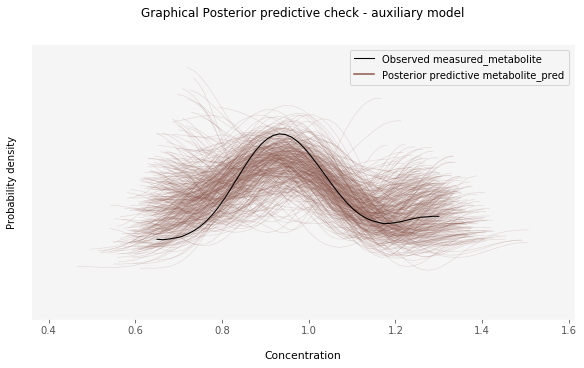

In [20]:
arviz.plot_ppc(infd_auxiliary, kind='density',
               mean=False,
               figsize=[8, 5],
               num_pp_samples=400,
               textsize=10,
               data_pairs={'measured_metabolite': 'metabolite_pred'})

ax = plt.gca()
text = ax.set(
    xlabel='Concentration', ylabel='Probability density',
    title='Graphical Posterior predictive check - auxiliary model'
)

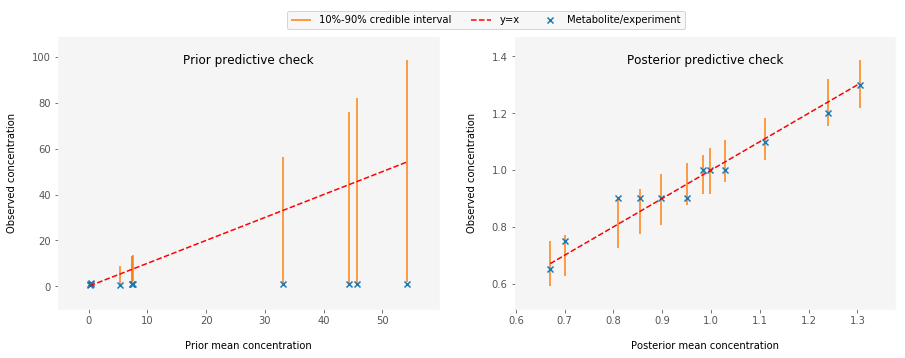

In [21]:
ppc_plot(infd_auxiliary)


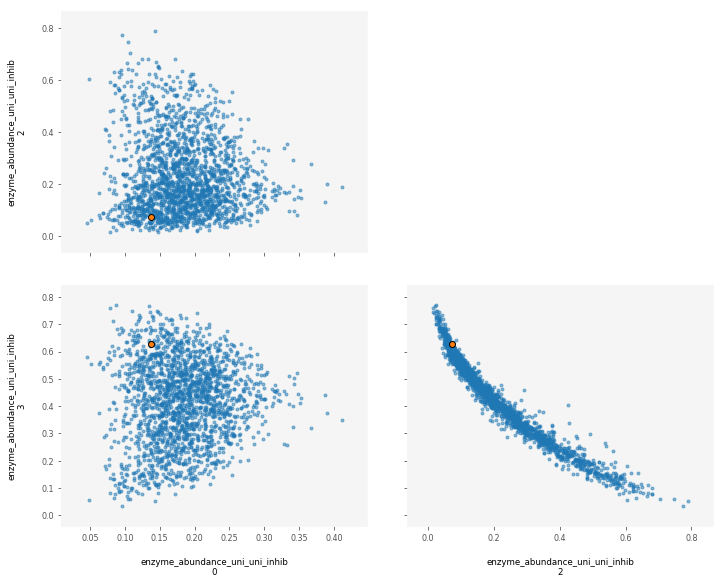

In [22]:
p = arviz.plot_pair(infd_auxiliary, 
                    var_names=['enzyme_abundance_uni_uni_inhib'], 
                    coords={'enzyme_abundance_uni_uni_inhib_dim_0': [0, 2, 3]},
                    figsize=[10, 8],
                    textsize=8,
                    divergences=True, 
                    plot_kwargs={'alpha': 0.5})

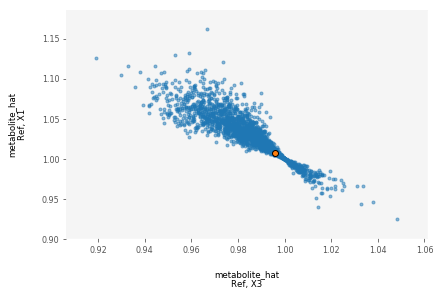

In [23]:
p = arviz.plot_pair(infd_auxiliary, 
                    var_names=['metabolite_hat'], 
                    coords={'experiments': ['Ref'], 'metabolites': ['X1', 'X3']},
                    textsize=8,
                    plot_kwargs={'alpha': 0.5},
                    divergences=True)

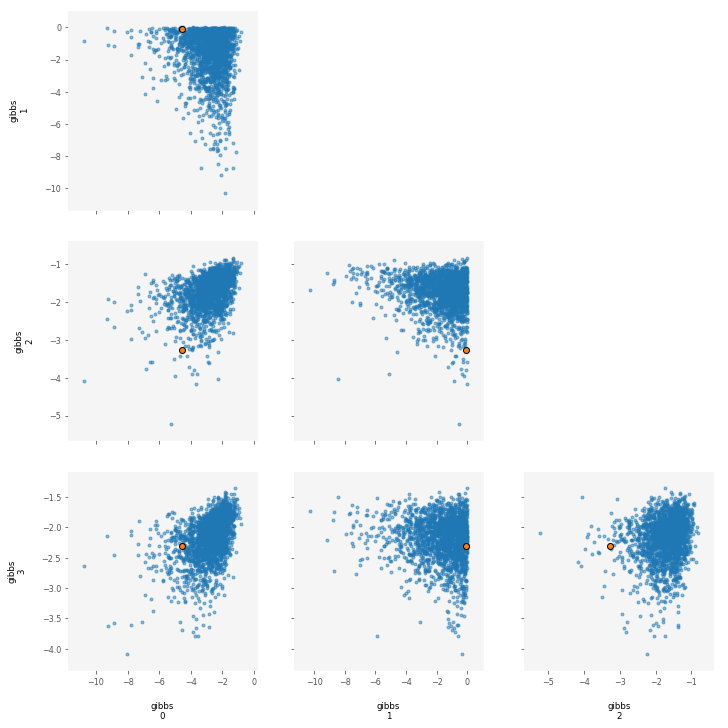

In [24]:
p = arviz.plot_pair(infd_auxiliary, 
                    var_names=['gibbs'], 
                    coords={'experiments': ['Ref', 'Ex_1'], 'metabolites': ['X1', 'X3']},
                    figsize=[10, 10],
                    textsize=8,
                    divergences=True,
                    plot_kwargs={'alpha': 0.5})